In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import numpy as np

In [2]:
image_directory = "DATA/"

In [3]:
def process(data):
  path = pathlib.Path(data)
  filepaths=list(path.glob(r"*/*.*"))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df=pd.concat([df1, df2],axis=1)
  return df

# memasukkan dataframe home ke dalam variabel df_root
df_root= process(image_directory)

os.listdir(image_directory)

['chicken_wings',
 'churros',
 'cup_cakes',
 'donuts',
 'french_fries',
 'fried_rice',
 'hamburger',
 'ice_cream',
 'kue_cokelat',
 'omelette']

In [4]:
df_root

filepaths         labels
0     DATA\chicken_wings\101104.jpg  chicken_wings
1     DATA\chicken_wings\103715.jpg  chicken_wings
2     DATA\chicken_wings\104370.jpg  chicken_wings
3     DATA\chicken_wings\105124.jpg  chicken_wings
4     DATA\chicken_wings\111683.jpg  chicken_wings
...                             ...            ...
2235         DATA\omelette\8093.jpg       omelette
2236        DATA\omelette\84313.jpg       omelette
2237        DATA\omelette\92386.jpg       omelette
2238        DATA\omelette\94651.jpg       omelette
2239        DATA\omelette\97045.jpg       omelette

[2240 rows x 2 columns]

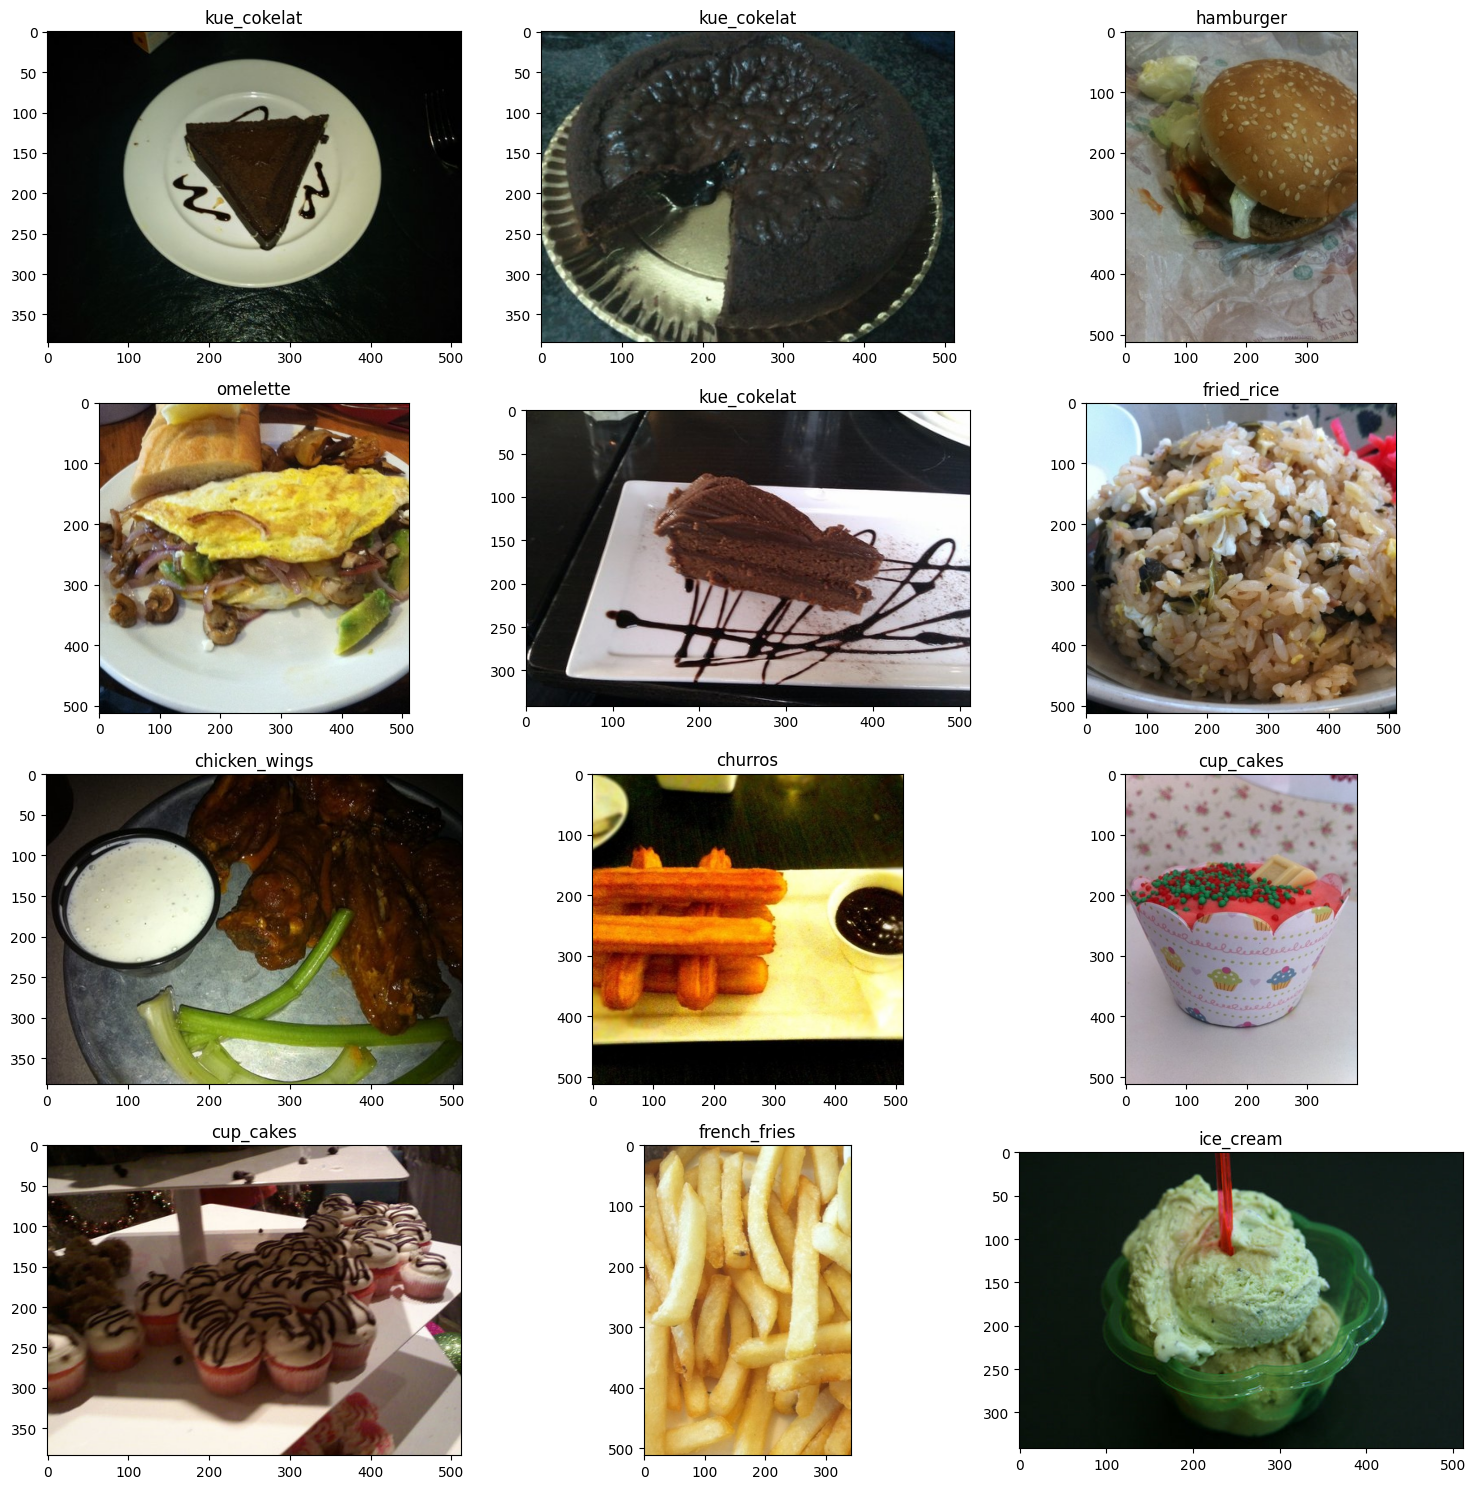

In [5]:
df_root = df_root.sample(frac=1).reset_index(drop=True)
fig, axes=plt.subplots(nrows=4,ncols=3,figsize=(15,15))

for i,ax in enumerate(axes.flat):
  x=plt.imread(df_root['filepaths'][i])
  ax.imshow(x)
  ax.set_title(df_root['labels'][i])
plt.tight_layout()
plt.show()

In [6]:
# Dataset split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_root, test_size=0.25, shuffle=True, random_state=1)
test_df, validation_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=1)

In [7]:
train_df

filepaths         labels
104   DATA\chicken_wings\658194.jpg  chicken_wings
2039   DATA\french_fries\547396.jpg   french_fries
1942        DATA\churros\250811.jpg        churros
1241     DATA\kue_cokelat\89732.jpg    kue_cokelat
1723  DATA\chicken_wings\364009.jpg  chicken_wings
...                             ...            ...
960         DATA\churros\511685.jpg        churros
905        DATA\hamburger\65141.jpg      hamburger
1096      DATA\cup_cakes\114847.jpg      cup_cakes
235    DATA\french_fries\653305.jpg   french_fries
1061     DATA\fried_rice\175944.jpg     fried_rice

[1680 rows x 2 columns]

In [40]:
image_width = 224
image_height = 224

image_dir = 'C:/Users/LENOVO/PycharmProjects/UhuyDevML/DATA'

training_datagen = ImageDataGenerator(rescale=1/255,
                                      horizontal_flip=True,
                                      zoom_range=0.2,
                                      fill_mode='nearest',
                                      shear_range=0.2)
val_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

# Make sure you used "categorical"
train_generator= training_datagen.flow_from_dataframe(dataframe = train_df,
                                                      target_size=(image_width,image_height),
                                                      x_col='filepaths',
                                                      y_col='labels',
                                                      batch_size=32,
                                                      class_mode='categorical')

validation_generator= val_datagen.flow_from_dataframe(dataframe = validation_df,
                                                      target_size=(image_width,image_height),
                                                      x_col='filepaths',
                                                      y_col='labels',
                                                      batch_size=32,
                                                      class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                  target_size=(image_width,image_height),
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                  batch_size=len(test_df),
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 1680 validated image filenames belonging to 10 classes.
Found 280 validated image filenames belonging to 10 classes.
Found 280 validated image filenames belonging to 10 classes.


In [23]:
from keras.layers import Input

model = tf.keras.applications.InceptionV3(weights="imagenet",
                                          include_top=False,
                                          input_tensor=Input(shape=(224, 224, 3)))


for layer in model.layers:
    layer.trainable = False

last_output = model.output

87910968/87910968 [==============================] - 26s 0us/step


In [24]:
inputs = model.input
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.models.Model(model.input, x)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_32 (Ba  (None, 111, 111, 32)         96        ['conv2d_42[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization_32[0

In [25]:
callback_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Ubah monitor ke 'val_loss' agar early stopping berdasarkan validation loss
    restore_best_weights=True,
    patience=10
)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks= callback_es,
                    verbose=1)

Epoch 1/30
53/53 [==============================] - 55s 989ms/step - loss: 2.2981 - accuracy: 0.2339 - val_loss: 1.6889 - val_accuracy: 0.5714
Epoch 2/30
53/53 [==============================] - 45s 843ms/step - loss: 1.7134 - accuracy: 0.4083 - val_loss: 1.2993 - val_accuracy: 0.6000
Epoch 3/30
53/53 [==============================] - 39s 740ms/step - loss: 1.4584 - accuracy: 0.5083 - val_loss: 1.0530 - val_accuracy: 0.6786
Epoch 4/30
53/53 [==============================] - 40s 757ms/step - loss: 1.3070 - accuracy: 0.5637 - val_loss: 0.9910 - val_accuracy: 0.6929
Epoch 5/30
53/53 [==============================] - 41s 771ms/step - loss: 1.2447 - accuracy: 0.5958 - val_loss: 0.9289 - val_accuracy: 0.7000
Epoch 6/30
53/53 [==============================] - 41s 777ms/step - loss: 1.1997 - accuracy: 0.6042 - val_loss: 0.9675 - val_accuracy: 0.7071
Epoch 7/30
53/53 [==============================] - 42s 792ms/step - loss: 1.1695 - accuracy: 0.6315 - val_loss: 0.9405 - val_accuracy: 0.7179

In [26]:
model.save("FoodModeloptAdam_InceptionV3.h5")

C:\Users\LENOVO\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


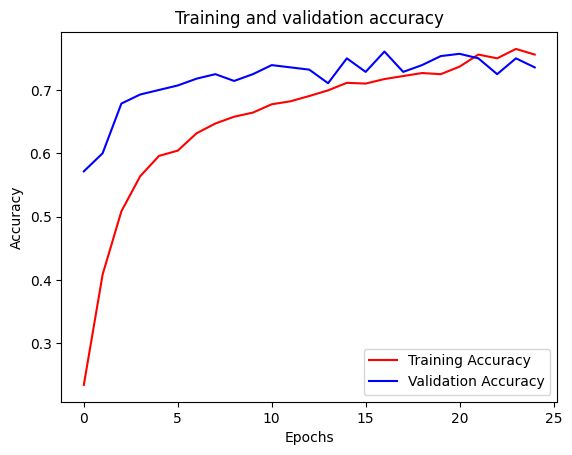

<Figure size 640x480 with 0 Axes>

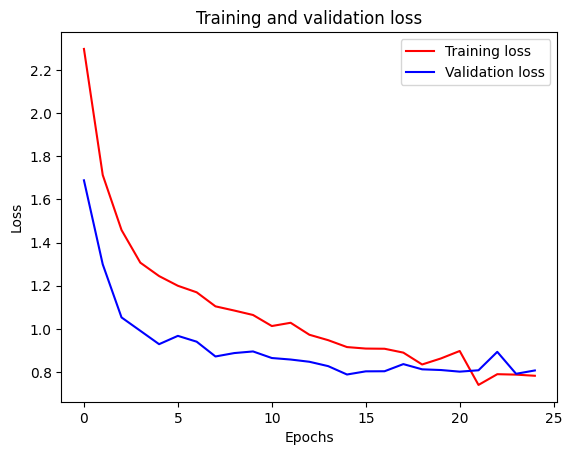

<Figure size 640x480 with 0 Axes>

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Membuat grafik plot untuk accuracy
plt.plot(epochs, acc, 'r', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Membuat grafik plot untuk loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [29]:
results = model.evaluate(test_generator, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

1/1 [==============================] - 5s 5s/step - loss: 0.7883 - accuracy: 0.7500
    Test Loss: 0.78828
Test Accuracy: 75.00%


In [31]:
model.evaluate(train_generator)

53/53 [==============================] - 31s 572ms/step - loss: 0.6029 - accuracy: 0.8196


[0.602909505367279, 0.8196428418159485]

In [37]:
model.evaluate(test_generator)

1/1 [==============================] - 4s 4s/step - loss: 0.7259 - accuracy: 0.7750


[0.7259016633033752, 0.7749999761581421]

9/9 [==============================] - 5s 485ms/step


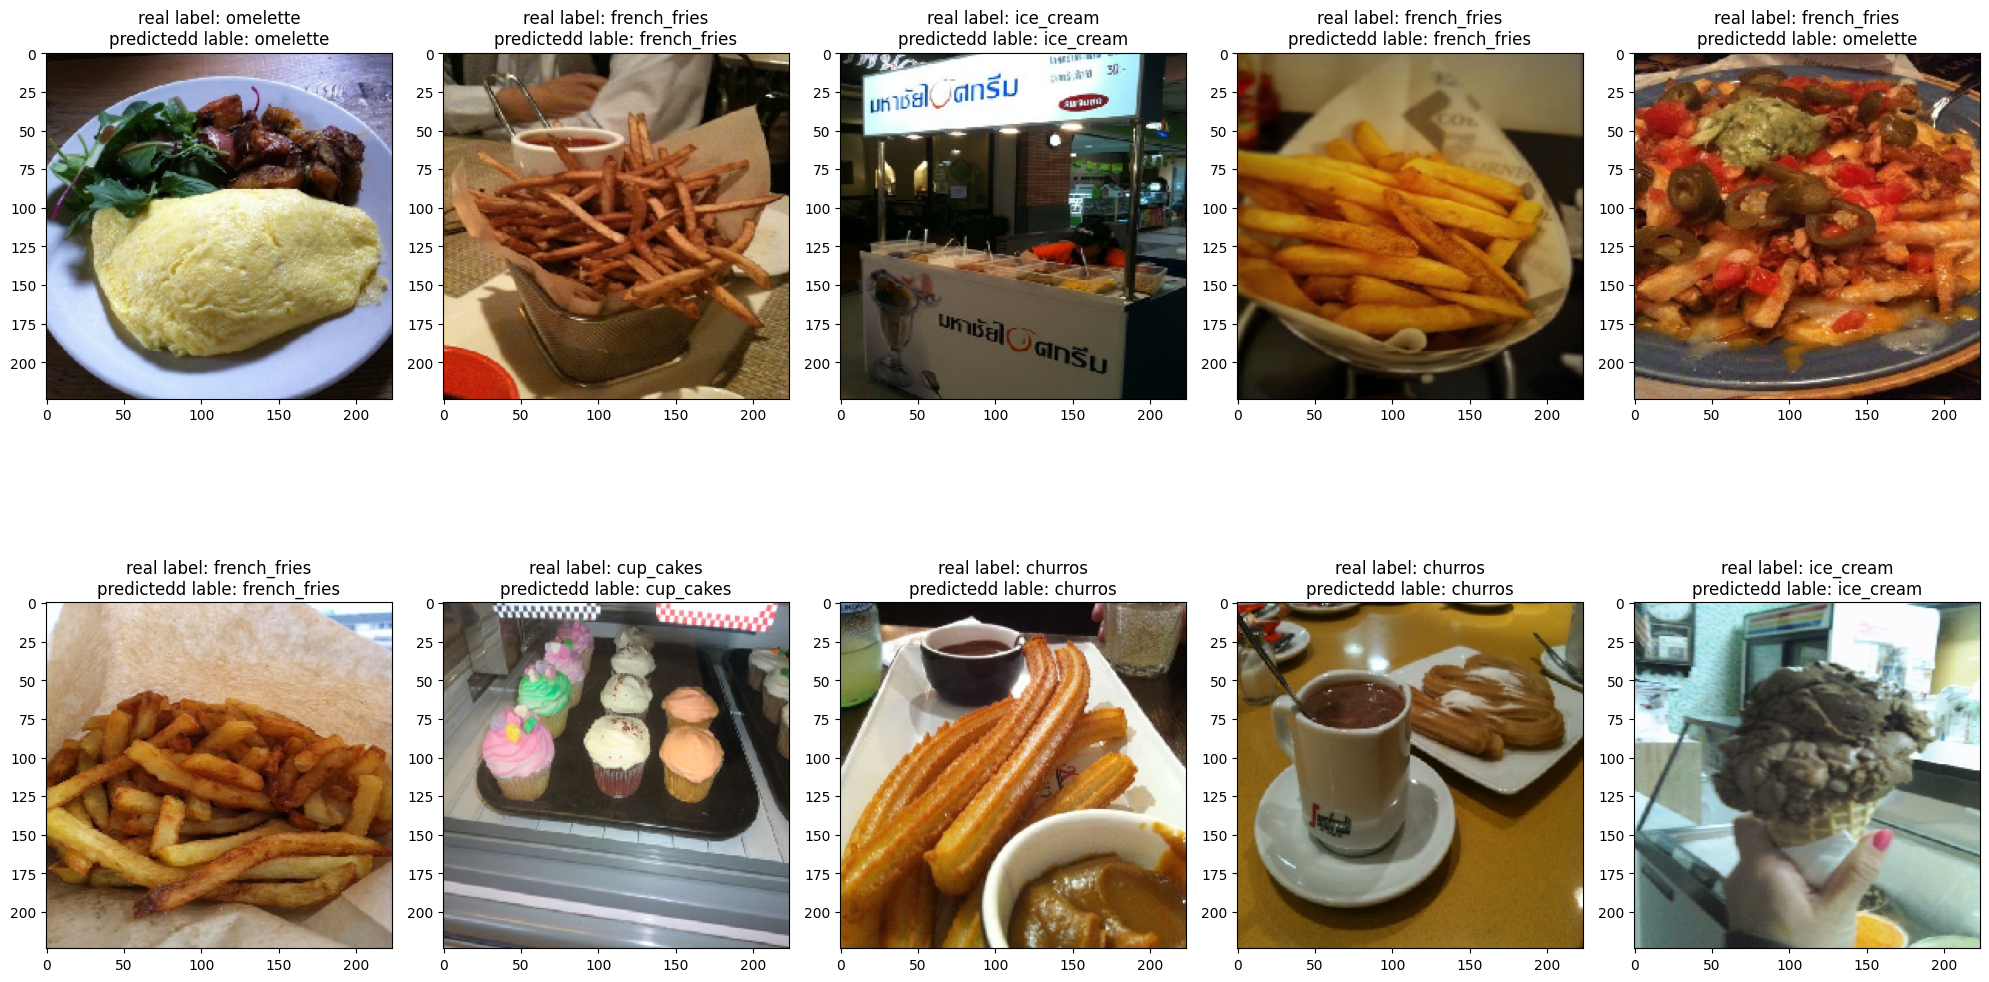

In [42]:
classes = ['chicken_wings', 'churros', 'cup_cakes', 'donuts', 'french_fries', 'fried_rice', 'hamburger', 'ice_cream', 'kue_cokelat', 'omelette']
images, labels = test_generator.next()
preds = model.predict(images)
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(20,12))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,10):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(classes[label]) + "\n" + "predictedd lable: " + str(classes[pred]))
    dic[i].imshow(image)
plt.tight_layout()
plt.show()

9/9 [==============================] - 4s 453ms/step - loss: 0.7259 - accuracy: 0.7750
Loss of the model is -  0.7259016633033752
Accuracy of the model is -  77.49999761581421 %
9/9 [==============================] - 4s 464ms/step
               precision    recall  f1-score   support

chicken_wings       0.84      0.70      0.76        23
      churros       0.77      0.77      0.77        31
    cup_cakes       0.76      0.84      0.80        31
       donuts       0.78      0.64      0.70        33
 french_fries       0.89      0.87      0.88        38
   fried_rice       0.80      0.89      0.84        27
    hamburger       0.81      0.71      0.76        24
    ice_cream       0.60      0.75      0.67        16
  kue_cokelat       0.73      0.79      0.76        24
     omelette       0.71      0.76      0.74        33

     accuracy                           0.78       280
    macro avg       0.77      0.77      0.77       280
 weighted avg       0.78      0.78      0.77       2

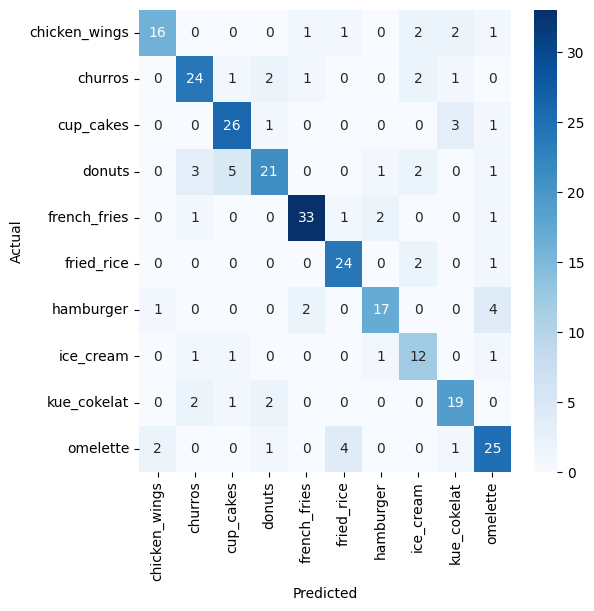

In [43]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_generator, class_names):
    test_images, test_labels = test_generator.next()
    # Evaluasi model dan cetak loss serta akurasi
    loss, accuracy = model.evaluate(test_images, test_labels)
    print('Loss of the model is - ', loss)
    print('Accuracy of the model is - ', accuracy * 100, '%')

    # Prediksi kelas
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Laporan klasifikasi
    print(classification_report(np.argmax(test_labels, axis=1), predicted_classes, target_names=class_names))

    # Matriks konfusi
    conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_classes)

    # Plot matriks konfusi
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(6, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

class_names = ['chicken_wings', 'churros', 'cup_cakes', 'donuts', 'french_fries', 'fried_rice', 'hamburger', 'ice_cream', 'kue_cokelat', 'omelette']

evaluate_model(model, test_generator, class_names)